In [26]:
%matplotlib inline
%pylab inline
from pathlib import Path
import menpo.io as mio
from menpo.landmark import labeller, left_ventricle_34,left_ventricle_34_trimesh
from menpo.feature import *
from menpowidgets import *
# method to load a database
def load_database(path_to_images, crop_percentage,max_diagonal=400, max_images=None):
    images = []
    # load landmarked images
    for i in mio.import_images(path_to_images, max_images=max_images, verbose=True):
        # crop image      
        i = i.crop_to_landmarks_proportion(crop_percentage)
        # convert it to grayscale if needed
        if i.n_channels == 3:
            i = i.as_greyscale(mode='luminosity')
        
        labeller(i, 'PTS', left_ventricle_34)#lv_34_trimesh
        labeller(i, 'PTS', left_ventricle_34_trimesh)
        d = i.diagonal()
        if d > max_diagonal:
            i = i.rescale(float(max_diagonal) / d)
        # append it to the list
        images.append(i)
    return images
crop_percentage = 0.5
path_to_lfpw = Path('K:/Datasets/ptstwo/')
train_images = load_database(path_to_lfpw/ 'trainset',crop_percentage,max_images=100)
test_images = load_database(path_to_lfpw/ 'testset' , crop_percentage,max_images=40)
#visualize_images(train_images)

Populating the interactive namespace from numpy and matplotlib
Found 84 assets, index the returned LazyList to import.


`%matplotlib` prevents importing * from pylab and numpy


Found 12 assets, index the returned LazyList to import.


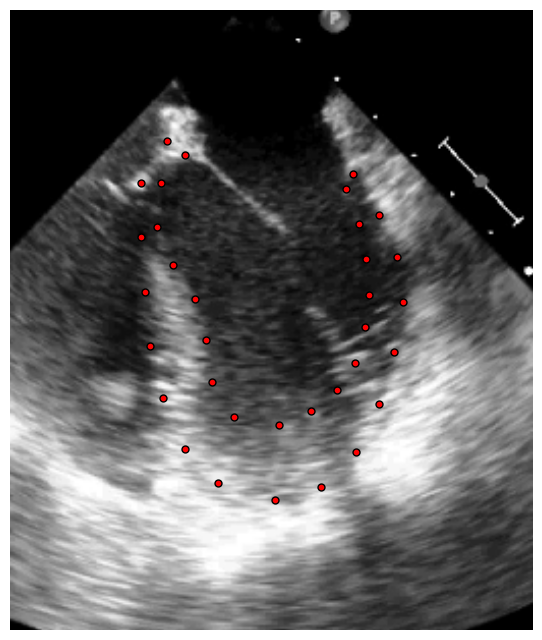

In [7]:
visualize_images(train_images)

## Active Appearance Models

#### Build

In [16]:
 
from menpofit.aam import HolisticAAM,PatchAAM

aam = PatchAAM(train_images, group='lv_34_trimesh', reference_shape=None,
                  diagonal=180, scales=(0.25, 0.5,1),
                  holistic_features=no_op, verbose=True)
print aam

- Computing reference shape                                                     Computing batch 0
- Building modelsges size: [==========] 100% (84/84) - done.                    
  - Scale 0: Doneding appearance model                                          
  - Scale 1: Doneding appearance model                                          
  - Scale 2: Doneding appearance model                                          
                                                              Patch-based Active Appearance Model
 - Images scaled to diagonal: 180.00
 - No image warping performed
 - Scales: [0.25, 0.5, 1]
   - Scale 0.25
     - Holistic feature: no_op
     - Appearance model class: PCAModel
       - 83 appearance components
     - Shape model class: OrthoPDM
       - 64 shape components
       - 4 similarity transform parameters
     - Patch shape: (17, 17)
   - Scale 0.5
     - Holistic feature: no_op
     - Appearance model class: PCAModel
       - 83 appearance components
     - Sha

In [17]:
# This is absolutely critical to decent AAM performance.
# We used two scales because we wanted to try and ensure
# that the first iterations of the AAM try and correct
# for the gross deformations that map to similarity misalignments.
# If you don't clip the number of shape components down, your
# fitting will NOT work! Intuitively, this is because the AAM
# is optimising over an energy function that is parametrised by 
# the shape components. The larger the dimensionality of the space,
# the higher the probability the space will contain many local optima.
# Similarly, the number of appearance components also cuts out a lot
# of the noise and improves fitting performance time.

# We also use a sampling pattern in order vastly improve
# the fitting efficiency.
from menpofit.aam import   LucasKanadeAAMFitter,AlternatingForwardCompositional
sampling = np.zeros(aam.patch_shape[0], dtype=np.bool)
sampling[:, ::4] = True
sampling[::4, :] = True

fitter = LucasKanadeAAMFitter(aam,lk_algorithm_cls=AlternatingForwardCompositional,
                                   sampling=sampling)
print fitter

Patch-based Active Appearance Model
 - Images scaled to diagonal: 180.00
 - No image warping performed
 - Scales: [0.25, 0.5, 1]
   - Scale 0.25
     - Holistic feature: no_op
     - Appearance model class: PCAModel
       - 83 appearance components
     - Shape model class: OrthoPDM
       - 64 shape components
       - 4 similarity transform parameters
     - Patch shape: (17, 17)
   - Scale 0.5
     - Holistic feature: no_op
     - Appearance model class: PCAModel
       - 83 appearance components
     - Shape model class: OrthoPDM
       - 64 shape components
       - 4 similarity transform parameters
     - Patch shape: (17, 17)
   - Scale 1
     - Holistic feature: no_op
     - Appearance model class: PCAModel
       - 83 appearance components
     - Shape model class: OrthoPDM
       - 64 shape components
       - 4 similarity transform parameters
     - Patch shape: (17, 17)
Alternating Forward Compositional Algorithm
 - Scales: [0.25, 0.5, 1]
   - Scale 0.25
     - 64 active s

In [27]:
from menpodetect import load_dlib_left_ventricle_detector
detector=load_dlib_left_ventricle_detector("./detector.svm")

np.random.seed(seed=1)
fitter_results = []
for j, i in enumerate(test_images[:]):    
    gt_s = i.landmarks['PTS'].lms
    i.landmarks['lv'] = gt_s.bounding_box()
    bboxes = detector(i)
    print("{} detected .".format(len(bboxes)))
    initial_bbox = bboxes[0]
    fr = fitter.fit_from_bb(i,  initial_bbox, max_iters=40, gt_shape=gt_s, return_costs=True )
    #fr.downscale = 0.5    
    fitter_results.append(fr)
    
    print 'Image: ', j
    print fr

1 detected .
Image:  0
Fitting result of 34 landmark points.
Initial error: 0.1737
Reconstructed initial error: 0.1737
Final error: 0.1635
1 detected .
Image:  1
Fitting result of 34 landmark points.
Initial error: 0.0961
Reconstructed initial error: 0.0961
Final error: 0.1390
1 detected .
Image:  2
Fitting result of 34 landmark points.
Initial error: 0.1088
Reconstructed initial error: 0.1088
Final error: 0.1222
1 detected .
Image:  3
Fitting result of 34 landmark points.
Initial error: 0.1124
Reconstructed initial error: 0.1124
Final error: 0.1444
1 detected .
Image:  4
Fitting result of 34 landmark points.
Initial error: 0.1179
Reconstructed initial error: 0.1179
Final error: 0.2800
1 detected .
Image:  5
Fitting result of 34 landmark points.
Initial error: 0.1454
Reconstructed initial error: 0.1454
Final error: 0.1012
1 detected .
Image:  6
Fitting result of 34 landmark points.
Initial error: 0.0883
Reconstructed initial error: 0.0883
Final error: 0.0851
1 detected .
Image:  7
Fitt

#### Plot CED

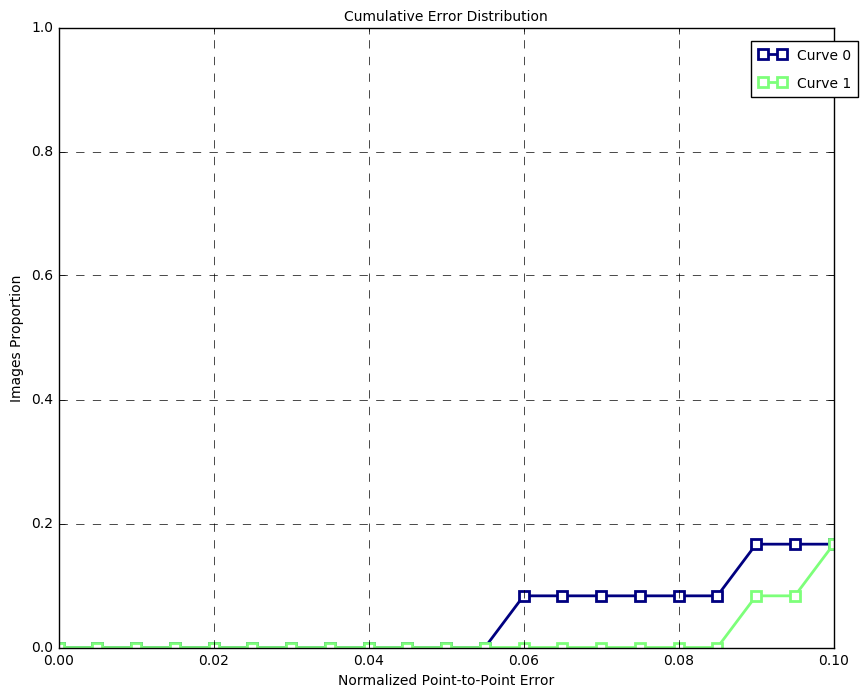

In [29]:
from menpofit.visualize import plot_cumulative_error_distribution

initial_errors = [fr.initial_error() for fr in fitter_results]
final_errors = [fr.final_error() for fr in fitter_results]
plot_cumulative_error_distribution([final_errors,initial_errors],legend_location=0)

#### Visualize results

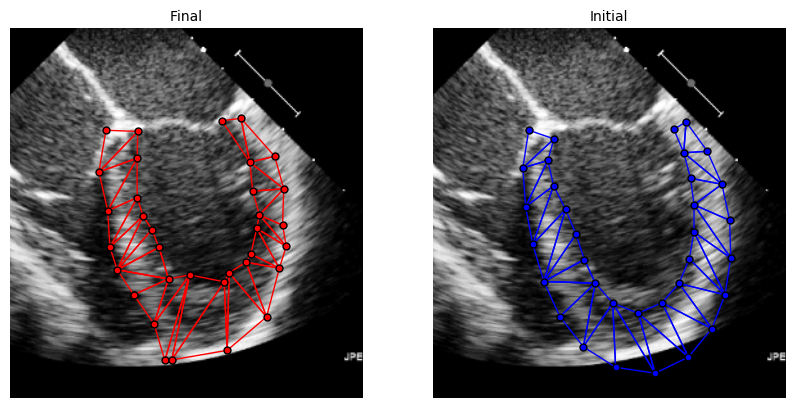

In [32]:
visualize_fitting_result(fitter_results)

## Constrained Local Models

#### Build

In [34]:
from fg2015.feature import no_op, aam_dsift
from fg2015.deformablemodel import CLMBuilder

offsets = np.meshgrid(range(-4, 5, 2), range(-4, 5, 2))
offsets = np.asarray([offsets[0].flatten(), offsets[1].flatten()]).T 

builder = CLMBuilder(parts_shape=(17, 17), features=aam_dsift, diagonal=200, 
                     offsets=offsets, normalize_parts=False, covariance=2, 
                     scale_shapes=False, scales=(1,))
clm = builder.build(training_images[:25], group='ibug_face_66', verbose=True)

ImportError: No module named fg2015.feature

In [ ]:
from menpofit.clm import CLM

offsets = np.meshgrid(range(-4, 5, 2), range(-4, 5, 2))
offsets = np.asarray([offsets[0].flatten(), offsets[1].flatten()]).T 

clm = CLM(
    train_images, group='lv_34', holistic_features=no_op, diagonal=180, scales=(0.5, 1), patch_shape=(17, 17),
    patch_normalisation=normalize_var, context_shape=(34, 34),  
    cosine_mask=True, sample_offsets=offsets,
    verbose=True, batch_size=None
)
print(clm)

- Computing reference shape                                                     Computing batch 0
- Training modelsges size: [==========] 100% (84/84) - done.                    
  - Scale 0: Donening experts: [==========] 100% (34/34) - done.                
  - Scale 1: Training experts: [=====     ] 55% (19/34) - 00:07:57 remaining    

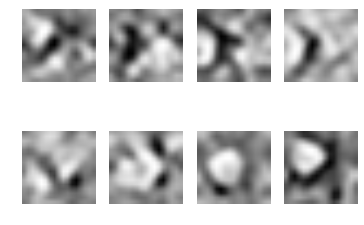

In [48]:
from fg2015.image import Image

Image(np.real(np.fft.fftshift(np.fft.ifft2(clm.classifiers[0][36].f)))).view()

In [49]:
from fg2015.utils import build_parts_image

ii = i.rescale_to_diagonal(200)
a = build_parts_image(ii, ii.landmarks['ibug_face_66'].lms, (17,17), offsets)

a.pixels.shape

(1, 66, 25, 17, 17)

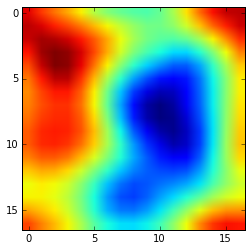

In [50]:
ch=0
part=34
offset=5

imshow(np.real(np.fft.ifft2(clm.classifiers[0][part].f[ch] * np.fft.fft2(a.pixels[ch, part, offset]))))

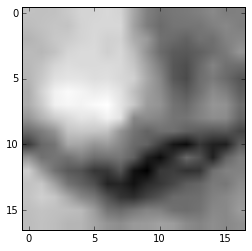

In [51]:
Image(a.pixels[ch, part, offset]).view()

#### Test

In [16]:
from fg2015.deformablemodel import CLMFitter
from fg2015.deformablemodel.clm import RLMS
                  
fitter = CLMFitter(clm, n_shape=[1])

In [17]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(training_images[:10]):
    
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitter.perturb_shape(gt_s, noise_std=0.00)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=50, prior=False)
    
    fitter_results.append(fr)
    
    print 'Image: ', j
    print fr

Image:  0
Initial error: 0.0507
Final error: 0.0882
Image:  1
Initial error: 0.0376
Final error: 0.1096
Image:  2
Initial error: 0.1020
Final error: 0.1462
Image:  3
Initial error: 0.0521
Final error: 0.1624
Image:  4
Initial error: 0.0565
Final error: 0.1236
Image:  5
Initial error: 0.0658
Final error: 0.1197
Image:  6
Initial error: 0.0501
Final error: 0.1178
Image:  7
Initial error: 0.0629
Final error: 0.1013
Image:  8
Initial error: 0.0434
Final error: 0.0880
Image:  9
Initial error: 0.0309
Final error: 0.1301


#### Plot CED

In [19]:
initial_errors = [fr.initial_error() for fr in fitter_results]
final_errors = [fr.final_error() for fr in fitter_results]

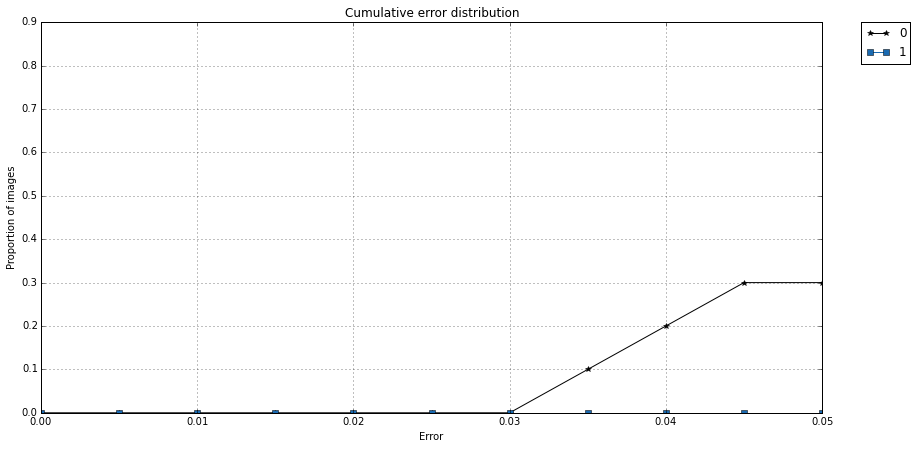

In [20]:
from menpo.visualize import plot_ced

plot_ced(final_errors, initial_errors=initial_errors)

#### Visualize results

In [21]:
fitted_images = [fr.iter_image for fr in fitter_results]

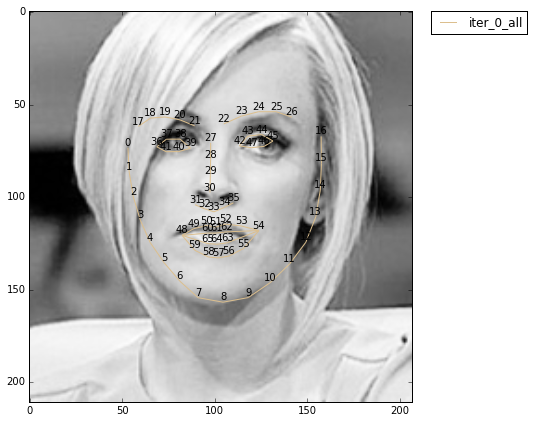

In [22]:
from menpo.visualize import browse_iter_images

browse_iter_images(fitted_images)